# Quantum Vision Transformers

Code to implement the method proposed in ["Quantum Vision Transformers"](https://openreview.net/forum?id=p7xPXoKB0H). The paper ["Quantum Methods for Neural Networks and Application to Medical Image Classification"](https://quantum-journal.org/papers/q-2022-12-22-881/) is also used as a reference.

In [1]:
import tensorcircuit as tc
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=150)
mpl.rcParams['figure.dpi'] = 50  # To make circuit plots smaller easily

2023-08-15 12:58:29.361867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U cirq`` to enable related functionality in translation module


## Reconfigurable Beam Splitter (RBS) gate

[0.   +0.j 0.841+0.j 0.54 +0.j 0.   +0.j]


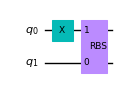

In [2]:
def rbs_gate(theta: float = 0.0):
    theta = tc.gates.num_to_tensor(theta)
    a = tc.cons.backend.cos(theta)
    b = tc.cons.backend.sin(theta)
    unitary = np.array([[1, 0, 0, 0], [0, a, b, 0], [0, -b, a, 0], [0, 0, 0, 1]])
    unitary = tc.cons.backend.reshape(unitary, [2, 2, 2, 2])
    return tc.gates.Gate(unitary)

# Register the RBS gate
tc.Circuit.rbs = tc.Circuit.apply_general_variable_gate_delayed(tc.gates.GateVF(rbs_gate, n="RBS"))

c = tc.Circuit(2)
c.x(0)
c.rbs(0, 1, theta=1)
print(np.around(c.state(), 3))
c.draw(output='mpl')

## Vector data loaders

### Diagonal

In [3]:
def normalize(x):
    return x / np.linalg.norm(x)

n = 8

rng = np.random.default_rng()
x = normalize(rng.random(n))
print(x)

[0.14558595 0.05388873 0.27077715 0.40387166 0.19222243 0.79370172 0.15007278 0.22368375]


In [4]:
def get_thetas_diagonal(x):
    thetas = np.empty(len(x) - 1)
    acc = 1
    for i in range(len(x) - 1):
        thetas[i] = np.arccos(np.clip(x[i] / acc, -1, 1))
        acc *= np.sin(thetas[i])
    return thetas

x_thetas_diagonal = get_thetas_diagonal(x)
print(x_thetas_diagonal)

[1.42469112 1.51630029 1.29314249 1.1317139  1.34535722 0.32717836 0.97985834]


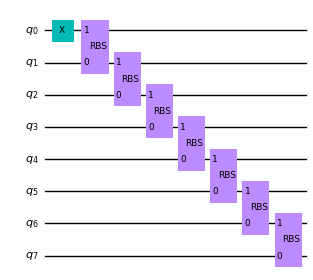

In [5]:
def diagonal_circuit(c: tc.Circuit, q: list[int], t: list[float], adjoint: bool = False, pauli_x: bool = False):
    if not adjoint:
        if pauli_x:
            c.x(q[0])
        
        for i in range(len(q) - 1):
            c.rbs(q[i], q[i+1], theta=t[i])
    else:
        for i in reversed(range(len(q) - 1)):
            c.rbs(q[i], q[i+1], theta=-t[i])

        if pauli_x:
            c.x(q[0])
    
    return c.state()

c = tc.Circuit(n)
diagonal_circuit_x_state = diagonal_circuit(c, range(n), x_thetas_diagonal, adjoint=False, pauli_x=True)
c.draw(output='mpl')

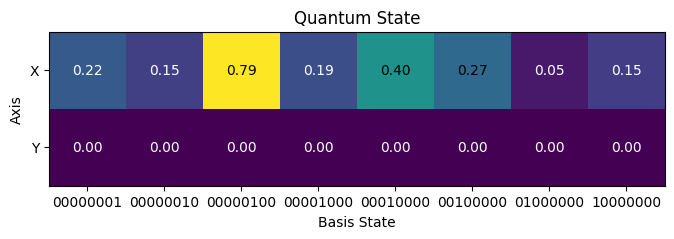

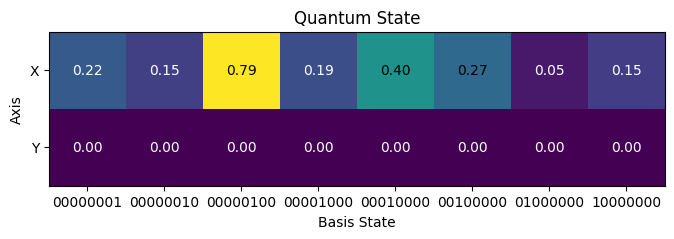

True

In [6]:
def e(i):
    c = tc.Circuit(len(x))
    c.x(i)
    return c.state()

def get_x_state(x):
    result = 0
    for i in range(len(x)):
        result += x[i] * e(i)
    return result / np.linalg.norm(x)

def visualize_quantum_state(state, remove_zero_columns=False):
    fig, ax = plt.subplots(dpi=100, figsize=(8, 2))
    img = np.vstack((state.real, state.imag))
    state_labels = np.array([bin(i)[2:].zfill(int(np.log2(len(state)))) for i in range(len(state))])
    if remove_zero_columns:
        zero_columns = np.any(img, axis=0)
        img = img[:, zero_columns]
        state_labels = state_labels[zero_columns]
    ax.imshow(img)
    ax.set_xticks(range(img.shape[1]))
    ax.set_xticklabels(state_labels)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["X", "Y"])
    ax.set_ylabel("Axis")
    ax.set_xlabel("Basis State")
    ax.set_title("Quantum State")

    for i in range(img.shape[1]):
        for j in range(2):
            ax.text(i, j, f"{img[j, i]:.2f}", ha="center", va="center", color="w" if img[j, i] < 0.25 else "k")

    plt.show()

original_state = get_x_state(x)
visualize_quantum_state(original_state, remove_zero_columns=True)
visualize_quantum_state(diagonal_circuit_x_state, remove_zero_columns=True)
np.allclose(original_state, diagonal_circuit_x_state)

#### Square inner product

0.6566525978391945 0.6566525960161884


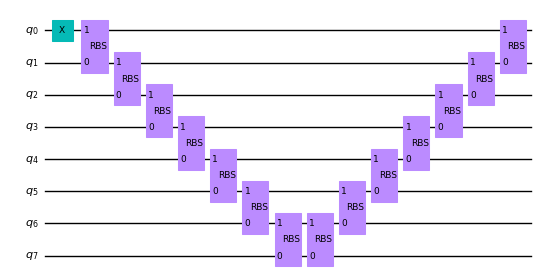

In [7]:
def diagonal_square_inner_product_circuit(c: tc.Circuit, q: list[int], x: list[float], w: list[float]):
    diagonal_circuit(c, q, x, pauli_x=True)
    diagonal_circuit(c, q, w, adjoint=True)
    return 1/2 - 1/2 * c.expectation([tc.gates.z(), [0]]).real

w = normalize(np.random.rand(n))
w_thetas_diagonal = get_thetas_diagonal(w)

c = tc.Circuit(n)
result = diagonal_square_inner_product_circuit(c, range(n), x_thetas_diagonal, w_thetas_diagonal)
print(result, np.dot(x, w)**2)
c.draw(output='mpl')

### Semi-diagonal

In [8]:
def get_thetas_semidiagonal(x):
    t = np.empty(len(x) - 1)
    t[1] = np.arctan2(x[0], x[1])
    t[-1] = np.arctan2(x[-1], x[-2])
    m = len(x) // 2 - 1
    for i in range(2, m+1):
        t[i] = np.arctan2(x[i-1], (x[i] * np.cos(t[i-1])))
    for i in range(len(x) - 3, m, -1):
        t[i] = np.arctan2(x[i+1], (x[i] * np.cos(t[i+1])))
    t[0] = np.arccos(x[m] / np.cos(t[m]))

    thetas = -np.ones_like(t)
    thetas[0] = t[0]
    for i in range(1, len(x)//2):
        thetas[-2*i] = t[i]
        thetas[-2*i+1] = t[-i]
    
    return thetas

x_thetas_semidiagonal = get_thetas_semidiagonal(x)
print(x_thetas_semidiagonal)

[1.03511947 0.65794809 1.34535722 0.52056362 0.32717836 1.21628389 0.97985834]


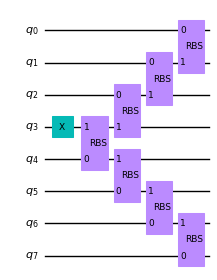

In [9]:
def semidiagonal_circuit(c: tc.Circuit, q: list[int], t: list[float], adjoint: bool = False, pauli_x: bool = False):
    m = len(q) // 2 - 1
    
    if not adjoint:
        if pauli_x:
            c.x(q[m])
        
        for i in range(len(q) // 2):
            c.rbs(q[m+i], q[m+i+1], theta=t[2*i])
            if m-i-1 >= 0:
                c.rbs(q[m-i], q[m-i-1], theta=t[2*i+1])
    else:
        for i in reversed(range(len(q) // 2)):
            if m-i-1 >= 0:
                c.rbs(q[m-i], q[m-i-1], theta=-t[2*i+1])
            c.rbs(q[m+i], q[m+i+1], theta=-t[2*i])

        if pauli_x:
            c.x(q[m])
    
    return c.state()

c = tc.Circuit(n)
semidiagonal_circuit_x_state = semidiagonal_circuit(c, range(n), x_thetas_semidiagonal, adjoint=False, pauli_x=True)
c.draw(output='mpl')

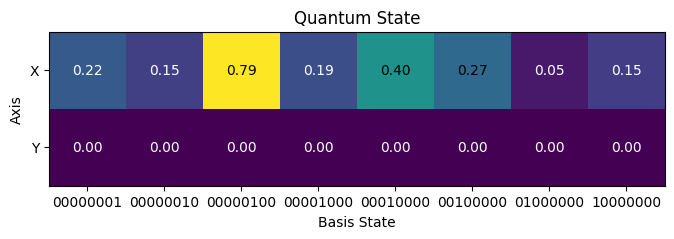

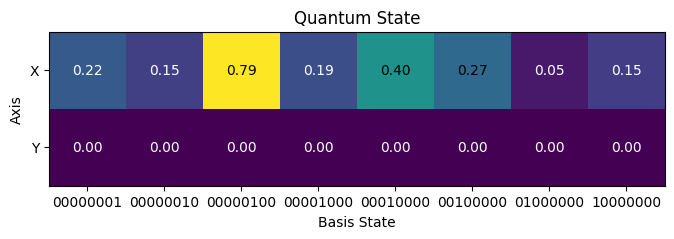

True

In [10]:
visualize_quantum_state(original_state, remove_zero_columns=True)
visualize_quantum_state(semidiagonal_circuit_x_state, remove_zero_columns=True)
np.allclose(original_state, semidiagonal_circuit_x_state)

#### Square inner product

0.656652622550405 0.6566525960161884


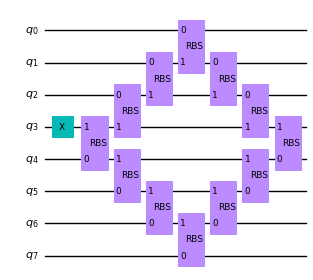

In [11]:
def semidiagonal_square_inner_product_circuit(c: tc.Circuit, q: list[int], x: list[float], w: list[float], pauli_x: bool = True):
    m = len(q) // 2 - 1
    semidiagonal_circuit(c, q[1:-1], x, pauli_x=pauli_x)
    c.rbs(q[1], q[0], theta=x[-2] - w[-2])
    c.rbs(q[-2], q[-1], theta=x[-1] - w[-1])
    semidiagonal_circuit(c, q[1:-1], w, adjoint=True)
    return 1/2 - 1/2 * c.expectation([tc.gates.z(), [m]]).real

w_thetas_semidiagonal = get_thetas_semidiagonal(w)

c = tc.Circuit(n)
result = semidiagonal_square_inner_product_circuit(c, range(n), x_thetas_semidiagonal, w_thetas_semidiagonal)
print(result, np.dot(x, w)**2)
c.draw(output='mpl')

#### Inner product

0.00899262787114119 0.008992630575019369
0.8103410653711122 0.8103410368580555


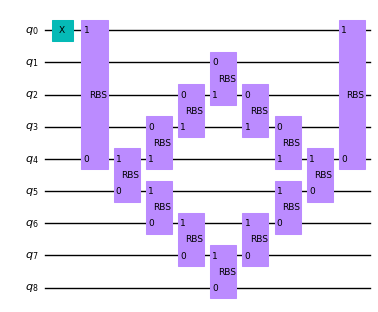

In [12]:
def semidiagonal_inner_product_circuit(c: tc.Circuit, q: list[int], x: list[float], w: list[float], pauli_x: bool = True):
    m = (len(q) - 1) // 2
    c.x(q[0])
    c.rbs(q[0], q[m], theta=np.pi/4)
    semidiagonal_square_inner_product_circuit(c, q[1:], x, w, pauli_x=False)
    c.rbs(q[0], q[m], theta=np.pi/4)
    return 1/2 - 1/2 * c.expectation([tc.gates.z(), [0]]).real

c = tc.Circuit(n + 1)
result = semidiagonal_inner_product_circuit(c, range(n + 1), x_thetas_semidiagonal, w_thetas_semidiagonal)
print(result, (1/2-np.dot(x, w)/2)**2)
print(1-2*np.sqrt(result), np.dot(x, w))
c.draw(output='mpl')

In [13]:
neg_w_thetas_semidiagonal = get_thetas_semidiagonal(-w)

c = tc.Circuit(n + 1)
result = semidiagonal_inner_product_circuit(c, range(n + 1), x_thetas_semidiagonal, neg_w_thetas_semidiagonal)
print(result, (1/2-np.dot(x, -w)/2)**2)
print(1-2*np.sqrt(result), np.dot(x, -w))

0.8193336765392936 0.8193336674330749
-0.8103410469182801 -0.8103410368580555


In [14]:
perp_w = normalize(scipy.linalg.null_space(np.atleast_2d(x))[:, 0])
perp_w_thetas_semidiagonal = get_thetas_semidiagonal(perp_w)

c = tc.Circuit(n + 1)
result = semidiagonal_inner_product_circuit(c, range(n + 1), x_thetas_semidiagonal, perp_w_thetas_semidiagonal)
print(result, (1/2-np.dot(x, perp_w)/2)**2)
print(1-2*np.sqrt(result), np.dot(x, perp_w))

0.25000001775016806 0.25
-3.550033556010135e-08 -2.862293735361732e-17


### Parallel

TODO

## Matrix data loaders

TODO

## Orthogonal layers

### Pyramid

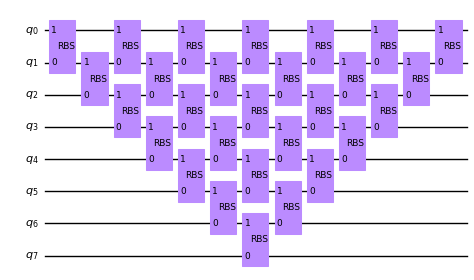

In [15]:
def pyramid_circuit(c: tc.Circuit, q: list[int], t: list[float]):
    k = 0
    for i in range(len(q)):
        for j in reversed(range(i)):
            c.rbs(q[j], q[j+1], theta=t[k])
            k += 1
    return c

c = tc.Circuit(n)
pyramid_circuit(c, range(n), range(n*(n-1)//2))
c.draw(output='mpl')

### X

TODO

### Butterfly

TODO

## Vision Transformers

### Quantum Orthogonal Patch-Wise Neural Network

TODO

### Quantum Orthogonal Transformer

TODO

### Quantum Compound Transformer

TODO